In [1]:
!pip install -q torch==1.0.0 torchvision

tcmalloc: large alloc 1073750016 bytes == 0x60ba8000 @  0x7f12009032a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl


In [0]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms

In [0]:
batch_size = 128
num_workers=0


In [5]:

transform = transforms.ToTensor()
train_data = datasets.SVHN(root='data',split='train',transform=transform,download=True)

train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=num_workers)


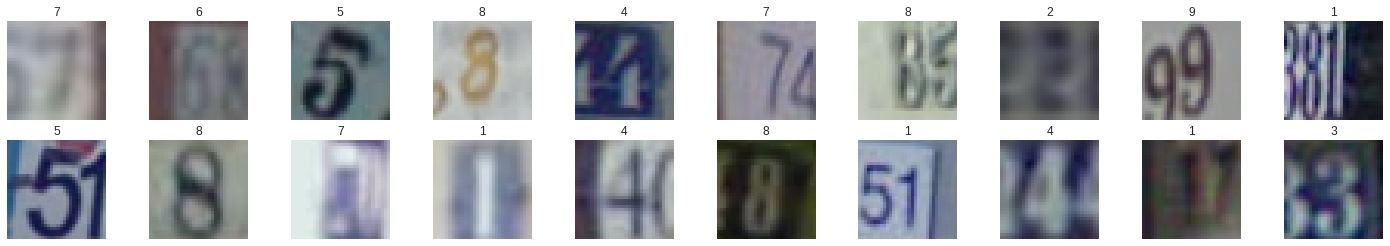

In [6]:
data_iter = iter(train_loader)
images,labels = data_iter.next()

fig = plt.figure(figsize=(25,4))
plot_size=20

for i in range(plot_size):
  ax=fig.add_subplot(2,plot_size/2,i+1,xticks=[],yticks=[])
  ax.imshow( np.transpose(images[i],(1,2,0)))
  ax.set_title(labels[i].item())

In [7]:
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.2941)
Max:  tensor(0.7569)


In [0]:
def scale(x, feature_range=(-1, 1)):
    
    return (x*2)-1.0


In [9]:
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.4118)
Scaled max:  tensor(0.5137)


In [0]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels,out_channels,kernel_size,stride=2,padding=1,batch_norm=True):
  
  layers=[]
  conv_layer = nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False)
  
  layers.append(conv_layer)
  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  
  return nn.Sequential(*layers)
  

In [0]:
class Discriminator(nn.Module):
  
  def __init__(self,input_size,conv_dim=32):
    super(Discriminator,self).__init__()
    
    self.conv_dim =conv_dim
    
    self.conv1 = conv(3,conv_dim,4,batch_norm=False)
    self.conv2 = conv(conv_dim,2*conv_dim,4)
    self.conv3 = conv(2*conv_dim,4*conv_dim,4)
    self.fc = nn.Linear(4*conv_dim*4*4,1)
    
  def forward(self,x):
    
    out = F.leaky_relu(self.conv1(x),0.2)
    out = F.leaky_relu(self.conv2(out),0.2)
    out = F.leaky_relu(self.conv3(out),0.2)
    
    out = out.view(-1,4*self.conv_dim*4*4)
    out = self.fc(out)
    
    return out
    
    
  

In [0]:
def deconv(in_channel,out_channel,kernel_size,stride=2,padding=1,batch_norm=True):
  layers=[]
  
  conv_trans = nn.ConvTranspose2d(in_channel,out_channel,kernel_size,stride,padding,bias=False)
  layers.append(conv_trans)
  
  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channel))
    
  return nn.Sequential(*layers)
  
  

In [0]:
class Generator(nn.Module):
  def __init__(self,z_size,conv_dim=32):
    
    super(Generator,self).__init__()
    self.conv_dim = conv_dim
    
    self.fc = nn.Linear(z_size,4*conv_dim*4*4)
    
    self.t_conv1 = deconv(4*conv_dim,2*conv_dim,4)
    self.t_conv2 = deconv(2*conv_dim,conv_dim,4)
    self.t_conv3 = deconv(conv_dim,3,4,batch_norm=False)
    
    
  def forward(self,x):
    
   
    out = self.fc(x)
    out = out.view(-1,self.conv_dim*4,4,4)
    
    out = F.relu(self.t_conv1(out))
    out = F.relu(self.t_conv2(out))
    out = self.t_conv3(out)
    out = torch.tanh(out)
    
    return out
    
    
  
  

In [43]:
# define hyperparams
conv_dim = 32
z_size = 100

# define discriminator and generator
D = Discriminator(conv_dim)
G = Generator(z_size=z_size, conv_dim=conv_dim)

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [44]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
  G=G.cuda()
  D=D.cuda()
  print('GPU available for training. Models moved to GPU')
else:
  print('Training on CPU.')
  

GPU available for training. Models moved to GPU


In [0]:
def real_loss(D_out,smooth=False):
  
  batch_size = D_out.size(0)
  if smooth:
    
    labels=torch.ones(batch_size)*0.9
  else:
    labels =torch.ones(batch_size)
    
  if train_on_gpu:
    labels = labels.cuda()
    
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(),labels)
  
  return loss
 
  
def fake_loss(D_out):
  batch_size = D_out.size(0)
  
  labels = torch.zeros(batch_size)
  if train_on_gpu:
    labels = labels.cuda()
    
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(),labels)
  
  return loss
  
  

In [0]:
from torch import optim

lr = 0.0002
beta1 = 0.5
beta2 = 0.999


d_optimizer = optim.Adam(D.parameters(),lr,[beta1,beta2])
g_optimizer = optim.Adam(G.parameters(),lr,[beta1,beta2])

In [47]:
import pickle as pkl

num_epochs=50

samples=[]
losses=[]
print_every = 300

sample_size=16
fixed_z = np.random.uniform(-1,1,size=(sample_size,z_size))
fixed_z = torch.from_numpy(fixed_z).float()

for epoch in range(num_epochs):
  
  for batch_i ,(real_images,_) in enumerate(train_loader):
    
    batch_size = real_images.size(0)
    
    real_images = scale(real_images)
    
    
    
    ##################
    # train discriminator
    #################
    
    d_optimizer.zero_grad()
    
    if train_on_gpu:
      real_images = real_images.cuda()
    
    D_real = D(real_images)
    d_real_loss = real_loss(D_real)
    
    
    z = np.random.uniform(-1,1,size=(batch_size,z_size))
    z = torch.from_numpy(z).float()
    if train_on_gpu:
      z = z.cuda()
      
    fake_images = G(z)
    D_fake = D(fake_images)
    d_fake_loss = fake_loss(D_fake)
    
    d_loss = d_real_loss + d_fake_loss
    d_loss.backward()
    d_optimizer.step()
    
    ####################
    # train generator
    ####################
    
    
    g_optimizer.zero_grad()
    z = np.random.uniform(-1,1,size=(batch_size,z_size))
    z = torch.from_numpy(z).float()
    
    if train_on_gpu:
      z = z.cuda()
    
    fake_images = G(z)
    G_fake = D(fake_images)
    g_loss = real_loss(G_fake)
    
    g_loss.backward()
    g_optimizer.step()
    
    if batch_i % print_every ==0:
      losses.append((d_loss.item(),g_loss.item()))
      print('Epoch {:5d}/{:5d} | d_loss:{:6.4f} | g_loss:{:6.4f}'.format(epoch+1,num_epochs,d_loss.item(),g_loss.item()))
 


  ## produce samples
  G.eval()
  if train_on_gpu:
    fixed_z = fixed_z.cuda()
  
  samples_z = G(fixed_z)
  samples.append(samples_z)
  
  ## return to train mode
  G.train()
  
with open ('train_samples.pkl','wb') as f:
  pkl.dump(samples,f)
  


Epoch     1/   50 | d_loss:1.4427 | g_loss:0.8011
Epoch     1/   50 | d_loss:0.4276 | g_loss:1.9133
Epoch     2/   50 | d_loss:0.5379 | g_loss:3.0098
Epoch     2/   50 | d_loss:1.2077 | g_loss:1.3490
Epoch     3/   50 | d_loss:0.8105 | g_loss:2.1720
Epoch     3/   50 | d_loss:0.6756 | g_loss:1.3575
Epoch     4/   50 | d_loss:0.7240 | g_loss:1.8110
Epoch     4/   50 | d_loss:0.6606 | g_loss:2.1179
Epoch     5/   50 | d_loss:0.5580 | g_loss:2.1204
Epoch     5/   50 | d_loss:0.8901 | g_loss:3.3281
Epoch     6/   50 | d_loss:0.7536 | g_loss:1.1779
Epoch     6/   50 | d_loss:0.6376 | g_loss:2.6747
Epoch     7/   50 | d_loss:0.8463 | g_loss:2.6438
Epoch     7/   50 | d_loss:0.4391 | g_loss:1.8964
Epoch     8/   50 | d_loss:0.4240 | g_loss:2.9382
Epoch     8/   50 | d_loss:0.5909 | g_loss:2.2890
Epoch     9/   50 | d_loss:0.3573 | g_loss:1.7588
Epoch     9/   50 | d_loss:0.4287 | g_loss:2.1082
Epoch    10/   50 | d_loss:0.3230 | g_loss:2.3576
Epoch    10/   50 | d_loss:0.4212 | g_loss:1.7171


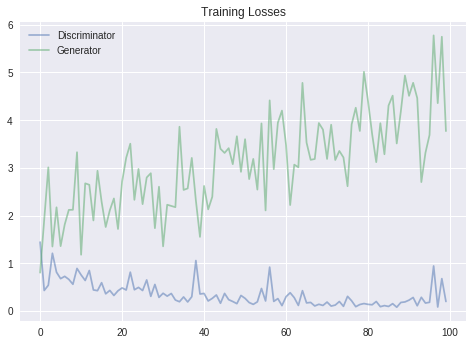

In [48]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [0]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

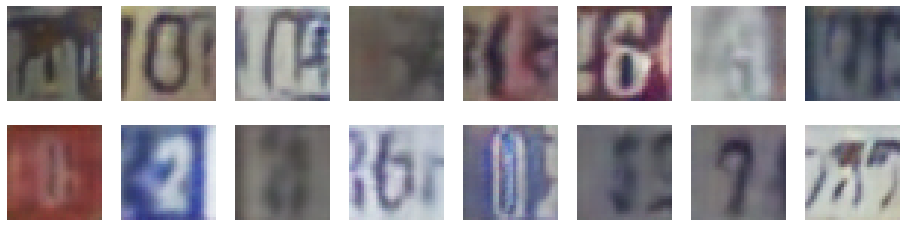

In [50]:
_ = view_samples(-1, samples)